# Prototyping Duck Status Dashboard
1. Extract duck path features ('path,' num_nodes', 'origin'_duck_coordinates', 'papa_duck_coordinates')
2. One main papa duck served as the terminating point (18.508568, -67.072667) - is there a better way to differentiate ducks than their coordinates? Id? Coordinates directly is convenient for plotting and calculations bit may have issues being a unique identifier.
3. Paths are rarely repeated - at least in test data. If they are commonly repeated, may be good to filter further by unique paths so we're not plotting overlapping paths
4. Distance from papa duck vs Number of messages transmitted - roughly shaped as reciprocal function but this test had relatively high number of requests from far away
5. Map ducks and the paths - have base layer of all ducks, then add_trace of each path on top of it
    - level 1 filter: to all paths containing the dot
    - level 2 filter: to only paths that originate from that duck
    - attempting to use color to replace arrow for direction but too many and too random to be meaningful currently
    - double clicking legend to selectively show paths is nice for isolating traces but not a very polished UI

# Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import ast

In [2]:
from sklearn.neighbors import DistanceMetric
from itertools import chain

In [3]:
pd.set_option('max_colwidth', -1)

# Load sample data

In [4]:
isabella = pd.read_csv('isabela_duck_deployment.csv', converters={'payload': ast.literal_eval})

In [5]:
isabella.head()

,Unnamed: 0,id,created_at,updated_at,event_type,payload,uuid,device_type,coordinates,path,path_coordinates
0,62,2714,11:40.5,11:40.5,civilian,"{'uuid': '5QOZlOxJECBv', 'civilian': {'info': {'name': 'Nick Feuer', 'phone': '1234567890', 'location': '18.508568,-67.072667', 'occupants': '2'}, 'status': {'danger': '1', 'vacant': '0'}, 'needs': {'first-aid': '1', 'water': '1', 'food': '0'}, 'message': 'Papa online!'}, 'path': '44E855A4AE30'}",5QOZlOxJECBv,papa-duck,"[18.508568, -67.072667]",44E855A4AE30,"[array([ 18.508568, -67.072667])]"
1,63,2715,12:33.1,12:33.1,civilian,"{'uuid': 'cVDXZ9fljbIh', 'civilian': {'info': {'name': 'Nick Feuer', 'phone': '1234567890', 'location': '18.508568,-67.072667', 'occupants': '2'}, 'status': {'danger': '1', 'vacant': '0'}, 'needs': {'first-aid': '1', 'water': '1', 'food': '0'}, 'message': 'I need help!'}, 'path': '44E855A4AE30'}",cVDXZ9fljbIh,papa-duck,"[18.508568, -67.072667]",44E855A4AE30,"[array([ 18.508568, -67.072667])]"
2,76,2728,21:32.9,21:32.9,civilian,"{'uuid': 'Qnhq1G5Rdwuv', 'civilian': {'info': {'name': 'Millie Morales', 'phone': '7875608448', 'location': '18.508555,-67.072667', 'occupants': '2'}, 'status': {'danger': '1', 'vacant': '0'}, 'needs': {'first-aid': '1', 'water': '1', 'food': '0'}, 'message': 'Please help us'}, 'path': 'C4408CBF713C'}",Qnhq1G5Rdwuv,papa-duck,"[18.508555, -67.072667]",C4408CBF713C,"[array([ 18.509781, -67.069342])]"
3,125,2777,08:31.4,08:31.4,civilian,"{'uuid': 'T1PaUmJjbFcO', 'civilian': {'info': {'name': 'Nick', 'phone': '1234567890', 'location': '18.509071,-67.074898', 'occupants': '2'}, 'status': {'danger': '1', 'vacant': '0'}, 'needs': {'first-aid': '1', 'water': '1', 'food': '0'}, 'message': 'I need help!'}, 'path': '50AD81E350CC,705BA9BF713C,AC65ABBF713C,44E855A4AE30'}",T1PaUmJjbFcO,papa-duck,"[18.509071, -67.074898]","50AD81E350CC,705BA9BF713C,AC65ABBF713C,44E855A4AE30","[array([ 18.509071, -67.074898]), array([ 18.511811, -67.074191]), array([ 18.508568, -67.072667]), array([ 18.508568, -67.072667])]"
4,127,2779,08:37.6,08:37.6,civilian,"{'uuid': 'T1PaUmJjbFcO', 'civilian': {'info': {'name': 'Nick', 'phone': '1234567890', 'location': '18.509071,-67.074898', 'occupants': '2'}, 'status': {'danger': '1', 'vacant': '0'}, 'needs': {'first-aid': '1', 'water': '1', 'food': '0'}, 'message': 'I need help!'}, 'path': '50AD81E350CC,705BA9BF713C,AC65ABBF713C,44E855A4AE30'}",T1PaUmJjbFcO,papa-duck,"[18.509071, -67.074898]","50AD81E350CC,705BA9BF713C,AC65ABBF713C,44E855A4AE30","[array([ 18.509071, -67.074898]), array([ 18.511811, -67.074191]), array([ 18.508568, -67.072667]), array([ 18.508568, -67.072667])]"


# Create potentially useful features
1. 'path': path in tuple form
2. 'num_nodes': number of nodes a message passes through
3. 'origin_duck_coordinates': lat,lon of duck that received the message
4. 'papa_duck_coordinates': lat,lon of papa_duck that pushed/uploaded the message


In [6]:
isabella['path_coordinates'].iloc[0:5].str.replace('array', '').str.replace('(', '').str.replace(')', '').map(ast.literal_eval)

0    [[18.508568, -67.072667]]                                                                           
1    [[18.508568, -67.072667]]                                                                           
2    [[18.509781, -67.069342]]                                                                           
3    [[18.509071, -67.074898], [18.511811, -67.074191], [18.508568, -67.072667], [18.508568, -67.072667]]
4    [[18.509071, -67.074898], [18.511811, -67.074191], [18.508568, -67.072667], [18.508568, -67.072667]]
Name: path_coordinates, dtype: object

In [7]:
def extract_path(path):
    """Parse the duck message path from string into a tuple """
    remove_array = path.replace('array', '').replace('(', '').replace(')', '')
    list_of_ducks = ast.literal_eval(remove_array)
    # use tuple of tuples so order is preserved and hashable to determine uniqueness 
    duck_tuples = [tuple(duck) for duck in list_of_ducks]
    duck_tuples = tuple(duck_tuples)
    return duck_tuples

In [8]:
isabella['path'] = isabella['path_coordinates'].map(extract_path)

In [9]:
isabella['num_nodes'] = isabella['path'].map(len)

In [10]:
isabella['num_nodes'].value_counts().sort_index().plot(kind='bar')

/home/douglas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

`Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.



In [11]:
isabella['origin_duck_coordinates'] = isabella['path'].map(lambda x:x[0])

In [12]:
isabella['papa_duck_coordinates'] = isabella['path'].map(lambda x:x[-1])

In [13]:
list(map(np.radians, ((18.508568, -67.072667), (18.508568, -67.072667))))


[array([ 0.32303545, -1.17063888]), array([ 0.32303545, -1.17063888])]

In [14]:
def great_circle_dist(coor1, coor2):
    """Calculate haversine distance between two points, coor1 and coor2
    and returns the distance in kilometers(km)
    coor1: tuple of (lat, lon) in degrees 
    coor2: tuple of (lat, lon) in degrees , should be coor of main papa duck
    Note: Found on SO: http://stackoverflow.com/a/41858332/380442"""
    dist = DistanceMetric.get_metric('haversine')
    
    X = list(map(np.radians, (coor1, coor2))) # convert from degrees to radians
    kms = 6372.8 # Earth radius
    return (kms * dist.pairwise(X)).max()

In [15]:
great_circle_dist((18.508568, -67.072667), (18.510475, -67.079757))

0.7773011819061204

In [16]:
list2d = [(18.508568, -67.072667), (18.508568, -67.072667)]

In [17]:
# good to know but should be a redundant calculation if ducks are stationary 
isabella['dist_from_pd'] = [great_circle_dist(papa, origin) for papa, origin in zip(isabella['papa_duck_coordinates'], isabella['origin_duck_coordinates'])]

In [18]:
list(chain(*list2d)) # not used

[18.508568, -67.072667, 18.508568, -67.072667]

In [19]:
isabella.columns

Index(['Unnamed: 0', 'id', 'created_at', 'updated_at', 'event_type', 'payload',
       'uuid', 'device_type', 'coordinates', 'path', 'path_coordinates',
       'num_nodes', 'origin_duck_coordinates', 'papa_duck_coordinates',
       'dist_from_pd'],
      dtype='object')

In [20]:
# possibly highlight paths that contain a certain duck
isabella['path'].map(lambda x: (18.509781, -67.069342) in x)

0     False
1     False
2     True 
3     False
4     False
      ...  
59    False
60    False
61    False
62    True 
63    True 
Name: path, Length: 64, dtype: bool

In [21]:
# looks like there was one main papa duck that served as terminating point
isabella.groupby('papa_duck_coordinates').size()

papa_duck_coordinates
(18.508568, -67.072667)    63
(18.509781, -67.069342)    1 
dtype: int64

In [22]:
# paths are rarely completley repeated -- at least in test data
isabella['path'].value_counts().head()

((18.511302, -67.062743), (18.508568, -67.072667), (18.508568, -67.072667))                                                                                                       2
((18.510475, -67.079757), (18.509224, -67.077522), (18.508568, -67.072667), (18.508568, -67.072667))                                                                              2
((18.512703, -67.067243), (18.510783, -67.066328), (18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.508568, -67.072667))                            2
((18.51064, -67.052121), (18.510992, -67.054925), (18.513456, -67.058507), (18.511302, -67.062743), (18.511811, -67.074191), (18.509947, -67.071246), (18.508568, -67.072667))    2
((18.513456, -67.058507), (18.511302, -67.062743), (18.509931, -67.06457), (18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.508568, -67.072667))    2
Name: path, dtype: int64

In [23]:
isabella.columns

Index(['Unnamed: 0', 'id', 'created_at', 'updated_at', 'event_type', 'payload',
       'uuid', 'device_type', 'coordinates', 'path', 'path_coordinates',
       'num_nodes', 'origin_duck_coordinates', 'papa_duck_coordinates',
       'dist_from_pd'],
      dtype='object')

In [24]:
# coordinates is the initial duck that received the message 
# last in path is the end duck

In [25]:
isabella[['id', 'uuid', 'device_type', 'path', 'num_nodes']].explode('path')['path']

0     (18.508568, -67.072667)
1     (18.508568, -67.072667)
2     (18.509781, -67.069342)
3     (18.509071, -67.074898)
3     (18.511811, -67.074191)
               ...           
63    (18.509931, -67.06457) 
63    (18.509696, -67.066926)
63    (18.509781, -67.069342)
63    (18.509947, -67.071246)
63    (18.508568, -67.072667)
Name: path, Length: 312, dtype: object

In [26]:
# Expand duck paths so each step has its own row
duck_paths = isabella[['id', 'uuid', 'device_type', 'path', 'num_nodes']].explode('path')

In [27]:
# rank('first') = number by appearance order within group
duck_paths['transmit_order'] = duck_paths.groupby('id')['id'].rank('first')

In [28]:
duck_paths['lat'] = duck_paths['path'].map(lambda x:x[0])
duck_paths['lon'] = duck_paths['path'].map(lambda x:x[1])

In [29]:
duck_paths.head(10)

,id,uuid,device_type,path,num_nodes,transmit_order,lat,lon
0,2714,5QOZlOxJECBv,papa-duck,"(18.508568, -67.072667)",1,1.0,18.508568,-67.072667
1,2715,cVDXZ9fljbIh,papa-duck,"(18.508568, -67.072667)",1,1.0,18.508568,-67.072667
2,2728,Qnhq1G5Rdwuv,papa-duck,"(18.509781, -67.069342)",1,1.0,18.509781,-67.069342
3,2777,T1PaUmJjbFcO,papa-duck,"(18.509071, -67.074898)",4,1.0,18.509071,-67.074898
3,2777,T1PaUmJjbFcO,papa-duck,"(18.511811, -67.074191)",4,2.0,18.511811,-67.074191
3,2777,T1PaUmJjbFcO,papa-duck,"(18.508568, -67.072667)",4,3.0,18.508568,-67.072667
3,2777,T1PaUmJjbFcO,papa-duck,"(18.508568, -67.072667)",4,4.0,18.508568,-67.072667
4,2779,T1PaUmJjbFcO,papa-duck,"(18.509071, -67.074898)",4,1.0,18.509071,-67.074898
4,2779,T1PaUmJjbFcO,papa-duck,"(18.511811, -67.074191)",4,2.0,18.511811,-67.074191
4,2779,T1PaUmJjbFcO,papa-duck,"(18.508568, -67.072667)",4,3.0,18.508568,-67.072667


In [30]:
ducks = duck_paths['path'].unique()

In [31]:
ducks

array([(18.508568, -67.072667), (18.509781, -67.069342),
       (18.509071, -67.074898), (18.511811, -67.074191),
       (18.509224, -67.077522), (18.510475, -67.079757),
       (18.51272, -67.079797), (18.512733, -67.0772),
       (18.511482, -67.071822), (18.508743, -67.072898),
       (18.509947, -67.071246), (18.509696, -67.066926),
       (18.510783, -67.066328), (18.512703, -67.067243),
       (18.509931, -67.06457), (18.511302, -67.062743),
       (18.513456, -67.058507), (18.512193, -67.055914),
       (18.510992, -67.054925), (18.51064, -67.052121)], dtype=object)

In [32]:
papa_duck = (18.508568, -67.072667)

In [34]:
[great_circle_dist(duck, papa_duck) for duck in ducks]

[0.0,
 0.3757545102932812,
 0.24187003688634537,
 0.3949010460241067,
 0.5172440438073778,
 0.7773011819061204,
 0.8824949637637212,
 0.6657264744763862,
 0.3361438971405185,
 0.031184788633646342,
 0.21445015436175785,
 0.6183815413093622,
 0.7125378157641473,
 0.7340320481039566,
 0.86736536459844,
 1.0899868499356948,
 1.589360189663697,
 1.8123930407891744,
 1.8906167991524832,
 2.179261260389874]

# Distance from papa duck vs Number of messages transmitted

In [35]:
# collect unique ducks and calculate their distances from a reference papa_duck into a dataframe
    # how to deal with moving ducks? is there a better identifier than location? 
duck_ref_table = pd.DataFrame({'duck_location':ducks, 'distance_from_papa_duck': [great_circle_dist(duck, (18.508568, -67.072667)) for duck in ducks]})

In [36]:
# count transmission frequency by counting up rows from exploded 
duck_frequency = pd.DataFrame(duck_paths.groupby('path').size().reset_index())
duck_frequency.columns = ['duck_location','transmission_freq']

In [37]:
duck_frequency.head()

,duck_location,transmission_freq
0,"(18.508568, -67.072667)",85
1,"(18.508743, -67.072898)",10
2,"(18.509071, -67.074898)",10
3,"(18.509224, -67.077522)",8
4,"(18.509696, -67.066926)",18


In [38]:
duck_dist_and_freq = pd.merge(duck_ref_table, duck_frequency, how='left', on='duck_location')

In [44]:
duck_dist_and_freq['lat'] = duck_dist_and_freq['duck_location'].map(lambda x:x[0])
duck_dist_and_freq['lon'] = duck_dist_and_freq['duck_location'].map(lambda x:x[1])

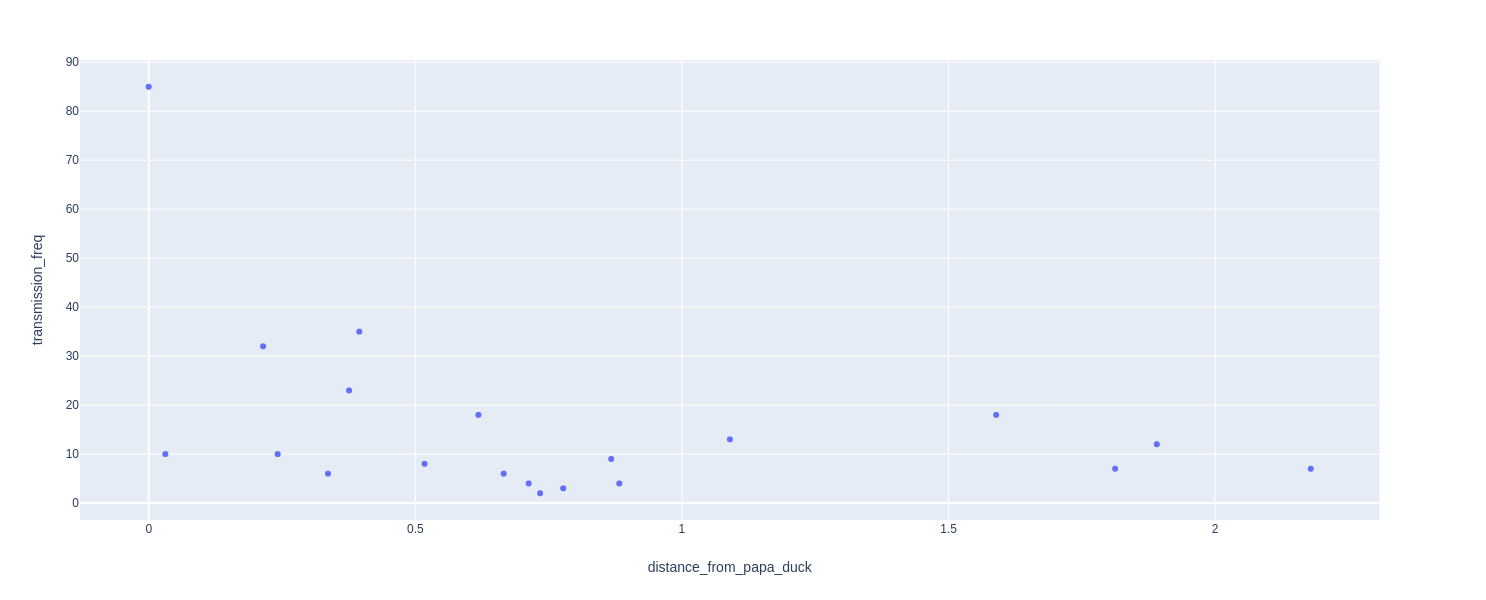

In [39]:
px.scatter(duck_dist_and_freq, x='distance_from_papa_duck', y='transmission_freq', hover_data=['duck_location'])
# Expect reciprocal function 

# Map ducks 

In [40]:
import plotly.graph_objects as go
import json

In [41]:
with open('./credentials.json', 'r') as f:
    credentials = json.load(f)
MAPBOX_TOKEN = credentials['token']

In [42]:
px.set_mapbox_access_token(MAPBOX_TOKEN)

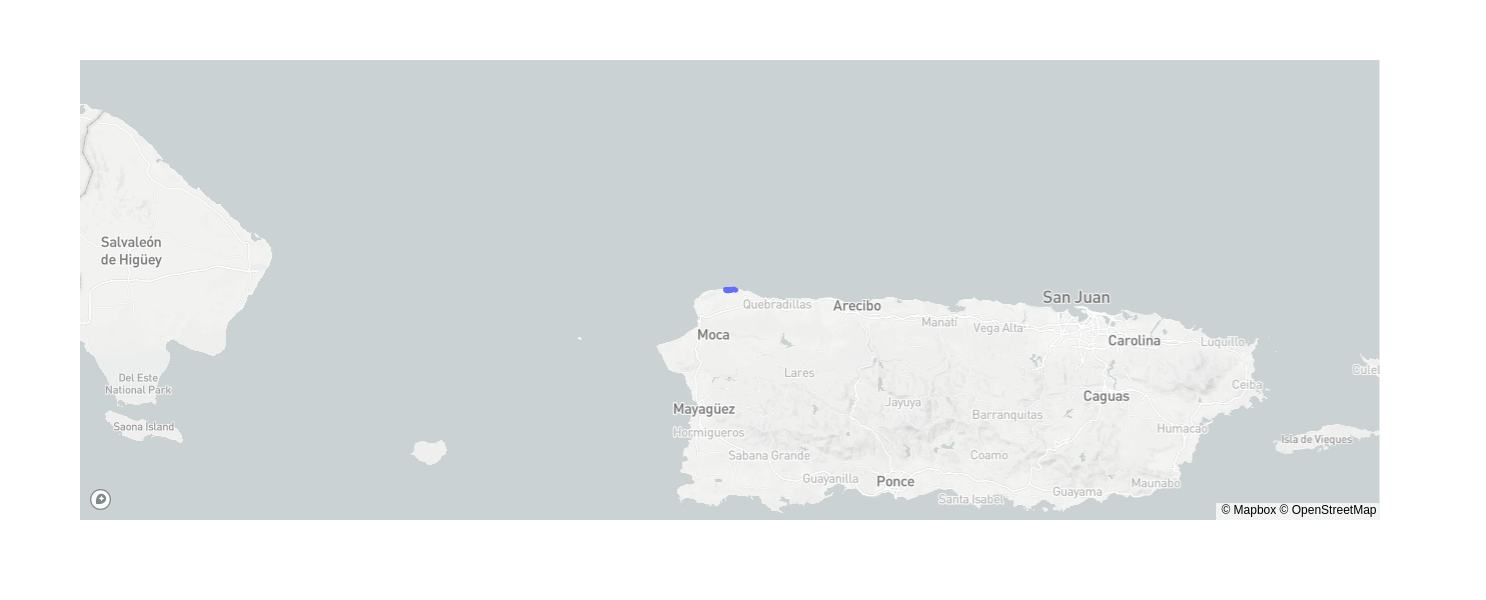

In [45]:
# Create base layer of just the ducks
fig = px.scatter_mapbox(duck_dist_and_freq, lat='lat', lon='lon', hover_data=['transmission_freq'] )
fig.show()

In [46]:
paths_with_duck = isabella.loc[isabella['path'].map(lambda x: (18.509781, -67.069342) in x), 'id'].tolist()

In [47]:
len(paths_with_duck)

23

In [48]:
isabella.loc[isabella['path'].map(lambda x: (18.509781, -67.069342) in x), ['id', 'path']].groupby('path')['id'].unique() # most paths have their own ducks 

path
((18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.508568, -67.072667))                                                                                                                                                        [2982, 2987]
((18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.508568, -67.072667), (18.508568, -67.072667))                                                                                                                               [2989]      
((18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.511811, -67.074191), (18.509071, -67.074898), (18.508568, -67.072667))                                                                                                      [2985]      
((18.509696, -67.066926), (18.509781, -67.069342), (18.509947, -67.071246), (18.511811, -67.074191), (18.509071, -67.074898), (18.508743, -67.072898), (18.508568, -67.072667))                         

In [49]:
duck_paths.loc[duck_paths['id'].isin(paths_with_duck)].head()

,id,uuid,device_type,path,num_nodes,transmit_order,lat,lon
2,2728,Qnhq1G5Rdwuv,papa-duck,"(18.509781, -67.069342)",1,1.0,18.509781,-67.069342
25,2964,KxqoWN44irrF,papa-duck,"(18.509781, -67.069342)",3,1.0,18.509781,-67.069342
25,2964,KxqoWN44irrF,papa-duck,"(18.509947, -67.071246)",3,2.0,18.509947,-67.071246
25,2964,KxqoWN44irrF,papa-duck,"(18.508568, -67.072667)",3,3.0,18.508568,-67.072667
26,2966,KxqoWN44irrF,papa-duck,"(18.509781, -67.069342)",4,1.0,18.509781,-67.069342


In [50]:
# duck_paths.loc[duck_paths['id'].isin(paths_with_duck)].groupby('id').size()

In [51]:
# for request_id, request_path in duck_paths.loc[duck_paths['id'].isin(paths_with_duck)].groupby('id'):
#     print(request_path['lat'])

# Level 1 Path Filter
 to all paths containing the dot 

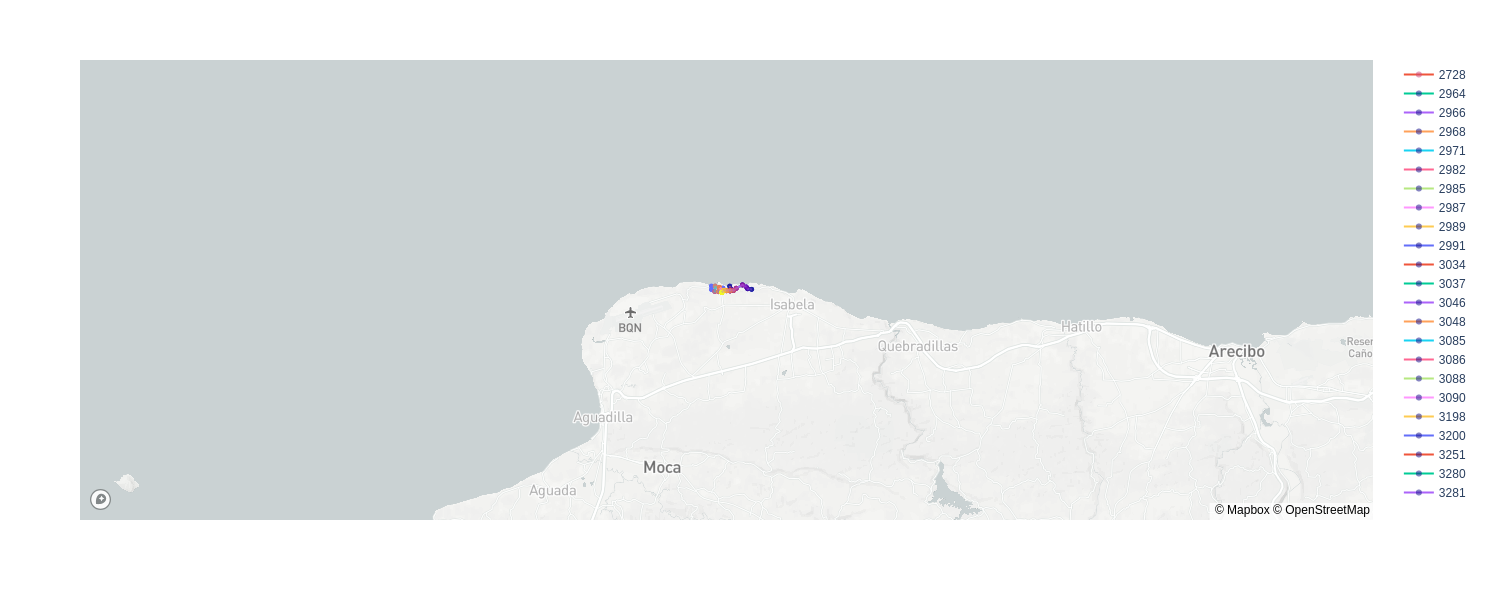

In [52]:
# base layer
fig = px.scatter_mapbox(duck_dist_and_freq, lat='lat', lon='lon', hover_data=['transmission_freq'] )
# level 1 filter: all shown paths pass through select node 
paths_with_duck = isabella.loc[isabella['path'].map(lambda x: (18.509781, -67.069342) in x), 'id'].tolist()
filtered_ducks = duck_paths.loc[duck_paths['id'].isin(paths_with_duck)]

# plot each request as its own trace
for request_id, request_path in filtered_ducks.groupby('id'):
    fig.add_trace(go.Scattermapbox(
                    lat=request_path['lat']
                    , lon=request_path['lon']
                    , name = request_id
                    , mode= 'lines+markers'
                    , marker={
                        'size':6
                        ,'opacity': 0.5
                        ,'color':request_path['transmit_order'] # changes color of markers 
                        , 'autocolorscale':True # use color instead of arrows to indicate direction? lose meaning with too many colors/traces
                    }
                    )
                 )
fig.update_layout(
        autosize=True,
        hovermode='closest',
        showlegend=True,
        clickmode= 'event+select', 
        mapbox=go.layout.Mapbox(
            accesstoken=MAPBOX_TOKEN,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=duck_paths['lat'].mean(),
                lon=duck_paths['lon'].mean()
            ),
            pitch=0,
            zoom=10,
#             style='satellite' # satellite not that important for duck status
    ))
fig.show()
# 2971 is an interesting one - took some extra hops to get to papa duck
# Double click on a path to isolate -- but it also removes the base layer - how to keep?

# Level 2 Path Filter 
 to only paths that originate from that duck

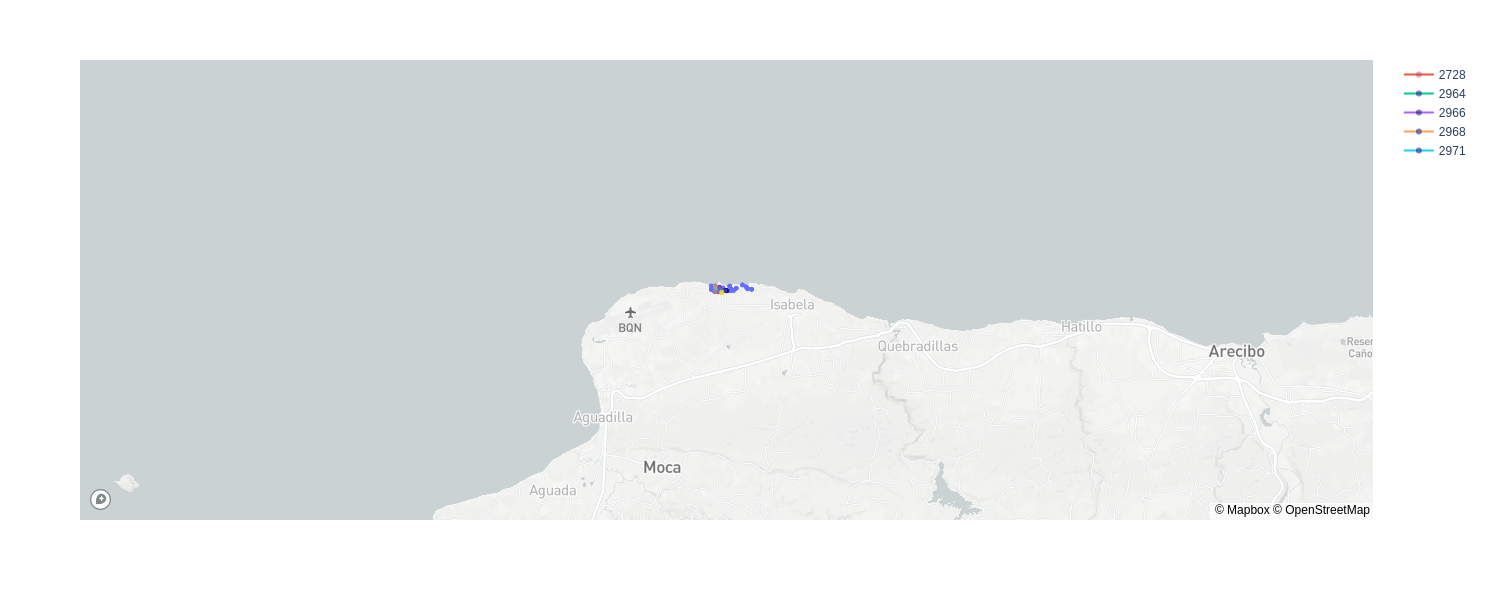

In [53]:
# base layer
fig = px.scatter_mapbox(duck_dist_and_freq, lat='lat', lon='lon', hover_data=['transmission_freq'] )
# level 1 filter: all shown paths pass through select node 
paths_with_duck = isabella.loc[isabella['origin_duck_coordinates'] == (18.509781, -67.069342), 'id'].tolist()
filtered_ducks = duck_paths.loc[duck_paths['id'].isin(paths_with_duck)]

# plot each request as its own trace
for request_id, request_path in filtered_ducks.groupby('id'):
    fig.add_trace(go.Scattermapbox(
                    lat=request_path['lat']
                    , lon=request_path['lon']
                    , name = request_id
                    , mode= 'lines+markers'
                    , marker={
                        'size':6
                        ,'opacity': 0.5
                        ,'color':request_path['transmit_order'] # changes color of markers 
                        , 'autocolorscale':True # use color instead of arrows to indicate direction? lose meaning with too many colors/traces
                    }
                    )
                 )
fig.update_layout(
        autosize=True,
        hovermode='closest',
        showlegend=True,
        clickmode= 'event+select', 
        mapbox=go.layout.Mapbox(
            accesstoken=MAPBOX_TOKEN,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=duck_paths['lat'].mean(),
                lon=duck_paths['lon'].mean()
            ),
            pitch=0,
            zoom=10,
#             style='satellite' # satellite not that important for duck status
    ))
fig.show()
# 2728 starts and stopped at  (18.509781, -67.069342) -- the only request that stopped here instead of the main papa duck 